# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

#plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("./datasets/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt("./datasets/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("./datasets/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt("./datasets/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt").astype(int)

In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [4]:
# Ваш код здесь
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [6]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [7]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [8]:
# Ваш код здесь
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65**
- 66
- 193

In [9]:
# Ваш код здесь
print(len(pca.components_))

65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51**
- 56
- 61

In [10]:
# Ваш код здесь
print(round(pca.explained_variance_ratio_[0] * 100))

51


Визуализируйте данные в проекции на первые две главные компоненты.

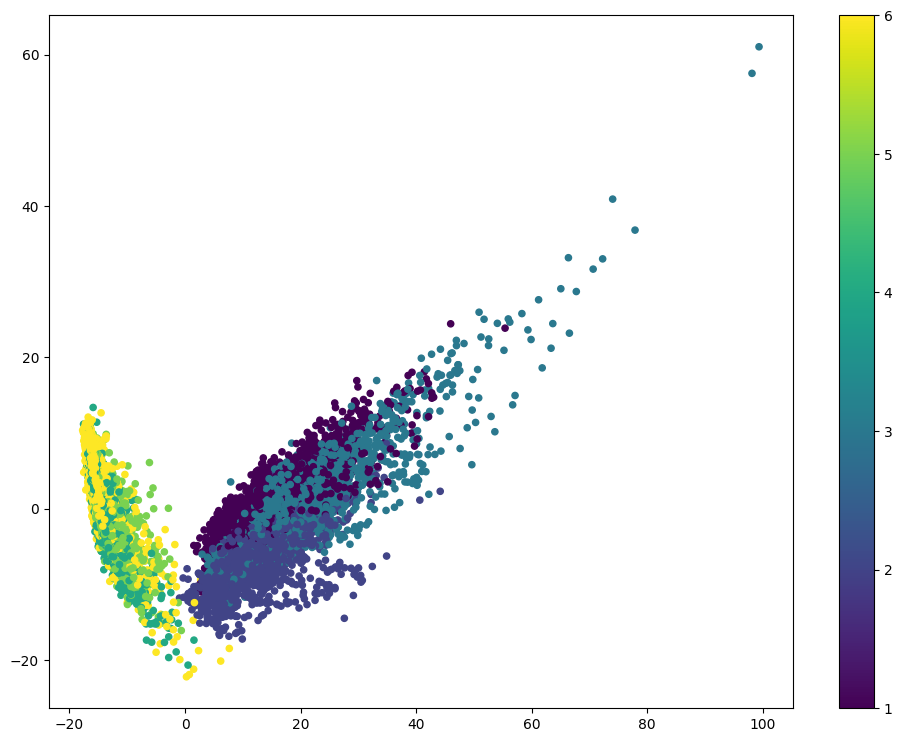

In [11]:
# Ваш код здесь
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
plt.colorbar()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [12]:
# Ваш код здесь
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
cluster_labels = kmeans.fit_predict(X_pca)
kmeans.inertia_
X_class = kmeans.fit(X_pca)
labels = X_class.predict(X_pca)

In [13]:
from scipy.spatial.distance import cdist

class CustomKMeans:
    def __init__(self, n_clusters, n_init=100, random_state=42, max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.random_state = random_state
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None
        self.assignments = None
        self.loss = None
    
    def _kmeans_pp_init(self, X):
        rng = np.random.RandomState(self.random_state)
        n_samples = X.shape[0]
        selected = [rng.randint(n_samples)]
        
        for _ in range(1, self.n_clusters):
            min_dists = np.min(cdist(X, X[selected]), axis=1)
            weights = min_dists ** 2 / np.sum(min_dists ** 2)
            selected.append(rng.choice(n_samples, p=weights))
        
        return X[selected]
    
    def _assign_samples(self, X, centrs):
        sq_dists = cdist(X, centrs, metric='euclidean')
        return np.argmin(sq_dists, axis=1)
    
    def _recalculate_centroids(self, X, assign):
        updated = np.zeros((self.n_clusters, X.shape[1]))
        for c in range(self.n_clusters):
            subset = X[assign == c]
            if len(subset) > 0:
                updated[c] = subset.mean(axis=0)
            else:
                updated[c] = X[np.random.randint(X.shape[0])]
        return updated
    
    def _compute_loss(self, X, assign, centrs):
        total_loss = 0
        for c in range(self.n_clusters):
            points = X[assign == c]
            if len(points) > 0:
                total_loss += np.sum((points - centrs[c]) ** 2)
        return total_loss
    
    def fit(self, X):
        X = np.asarray(X)
        optimal_loss = np.inf
        optimal_centroids = None
        optimal_assignments = None
        
        for attempt in range(self.n_init):
            current = self._kmeans_pp_init(X)
            
            for epoch in range(self.max_iter):
                assign = self._assign_samples(X, current)
                updated = self._recalculate_centroids(X, assign)
                
                if np.linalg.norm(updated - current) < self.tol:
                    current = updated
                    break
                current = updated
            
            loss = self._compute_loss(X, assign, current)
            if loss < optimal_loss:
                optimal_loss = loss
                optimal_centroids = current
                optimal_assignments = assign
        
        self.centroids = optimal_centroids
        self.assignments = optimal_assignments
        self.loss = optimal_loss
        return self
    
    def predict(self, X):
        X = np.asarray(X)
        sq_dists = cdist(X, self.centroids)
        return np.argmin(sq_dists, axis=1)
    
    def fit_predict(self, X):
        return self.fit(X).assignments


custom_km = CustomKMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
custom_km.fit(X_pca)

cluster_labels = custom_km.assignments
print(custom_km.loss)


2003454.798299288


2003454.8999158153 = 2003454.798299288 (ну, почти =)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

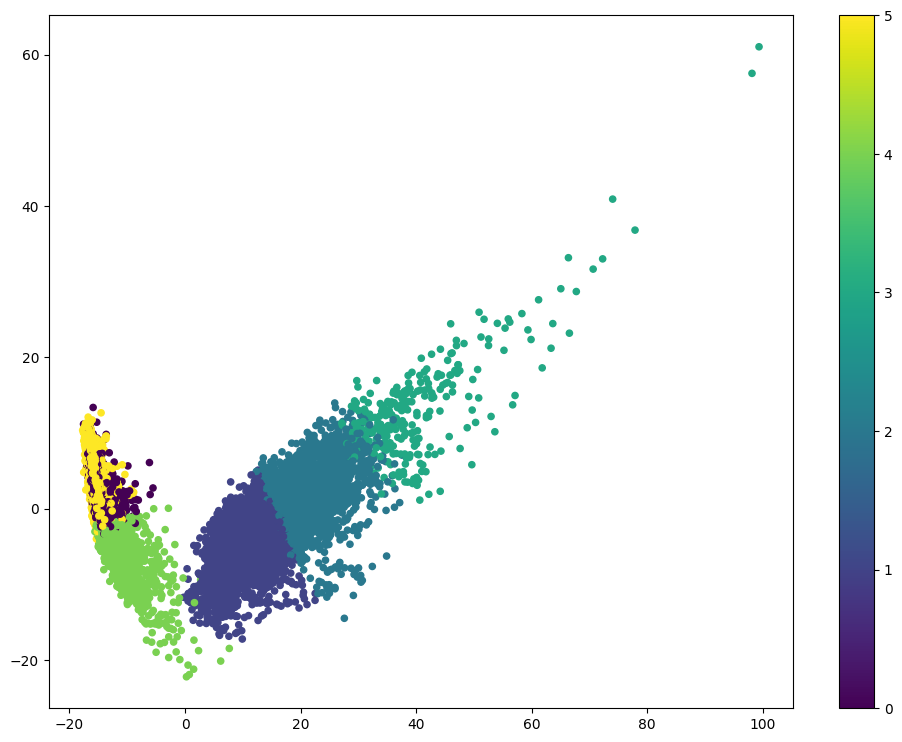

In [14]:
# Ваш код здесь
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=20,  cmap='viridis')
plt.colorbar()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [15]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,903,0,0,0,78,741,1722
подъем вверх по лестнице,1241,0,0,2,5,296,1544
спуск по лестнице,320,0,0,0,196,890,1406
сидение,1,91,1235,450,0,0,1777
стояние,0,0,1344,562,0,0,1906
лежание,5,1558,52,329,0,0,1944
все,2470,1649,2631,1343,279,1927,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят**

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

100%|██████████| 6/6 [00:51<00:00,  8.63s/it]


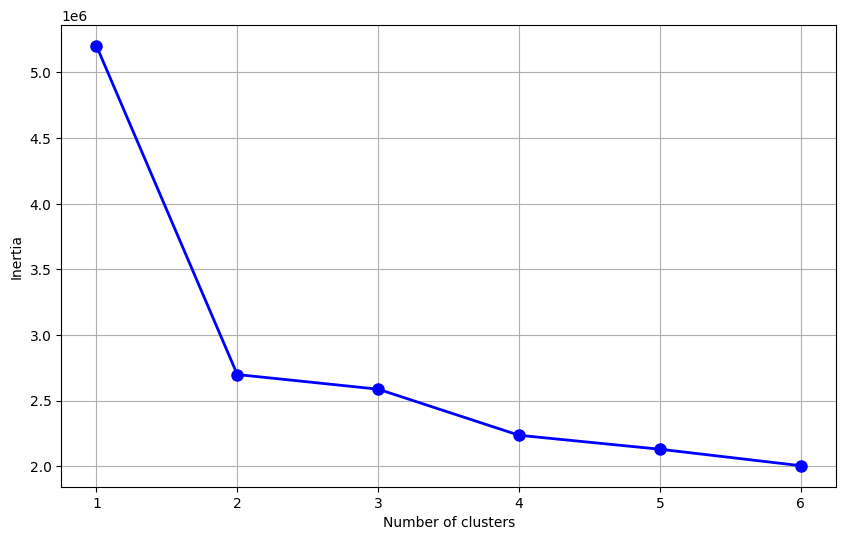

Inertia values: [np.float64(5202757.681643928), np.float64(2697926.7582298797), np.float64(2586456.343299129), np.float64(2235320.630228328), np.float64(2129036.3661943916), np.float64(2003454.798299288)]


In [16]:
# Ваш код здесь
from tqdm import tqdm

inertia_values = []
for k in tqdm(range(1, n_classes + 1)):
    km = CustomKMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    km.fit(X_pca)
    inertia_values.append(km.loss)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_classes + 1), inertia_values, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()
print(f"Inertia values: {inertia_values}")


**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2**
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [17]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [18]:
# Ваш код здесь
from sklearn.metrics import adjusted_rand_score

ari_custom = adjusted_rand_score(y, cluster_labels)
kmeans_sklearn = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans_sklearn.fit(X_pca)
ari_sklearn = adjusted_rand_score(y, kmeans_sklearn.labels_)
print(f"ARI: {ari_custom}")
print(f"ARI (sklearn): {ari_sklearn}")


ARI: 0.4198070012602345
ARI (sklearn): 0.4198070012602345


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [19]:
# Ваш код здесь
scaler_svc = StandardScaler()
X_train_scaled = scaler_svc.fit_transform(X_train)
X_test_scaled = scaler_svc.transform(X_test)

In [20]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [21]:
# Ваш код здесь
grid_svc = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1)
grid_svc.fit(X_train_scaled, y_train)
best_svc = grid_svc.best_estimator_

In [22]:
# Ваш код здесь
print(f"Best C: {grid_svc.best_params_['C']}")
print(f"Best CV score: {grid_svc.best_score_:.4f}")

y_predicted = best_svc.predict(X_test_scaled)

Best C: 0.1
Best CV score: 0.9380


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

In [23]:
y_predicted = best_svc.predict(X_test_scaled)

In [24]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние**

In [25]:
# Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA

pca_svc = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca_svc.fit_transform(X_train_scaled)
X_test_pca = pca_svc.transform(X_test_scaled)

grid_svc_pca = GridSearchCV(LinearSVC(random_state=RANDOM_STATE, max_iter=5000), 
                            svc_params, cv=3, n_jobs=-1)
grid_svc_pca.fit(X_train_pca, y_train)
score_without_pca = grid_svc.best_score_
score_with_pca = grid_svc_pca.best_score_
diff = round((score_without_pca - score_with_pca) * 100)

print(f"CV score без PCA: {score_without_pca}")
print(f"CV score с PCA: {score_with_pca}")
print(f"Разница: {diff}%")


CV score без PCA: 0.9379785010699506
CV score с PCA: 0.8983982658750974
Разница: 4%


Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- **4%**
- 10%
- 20%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

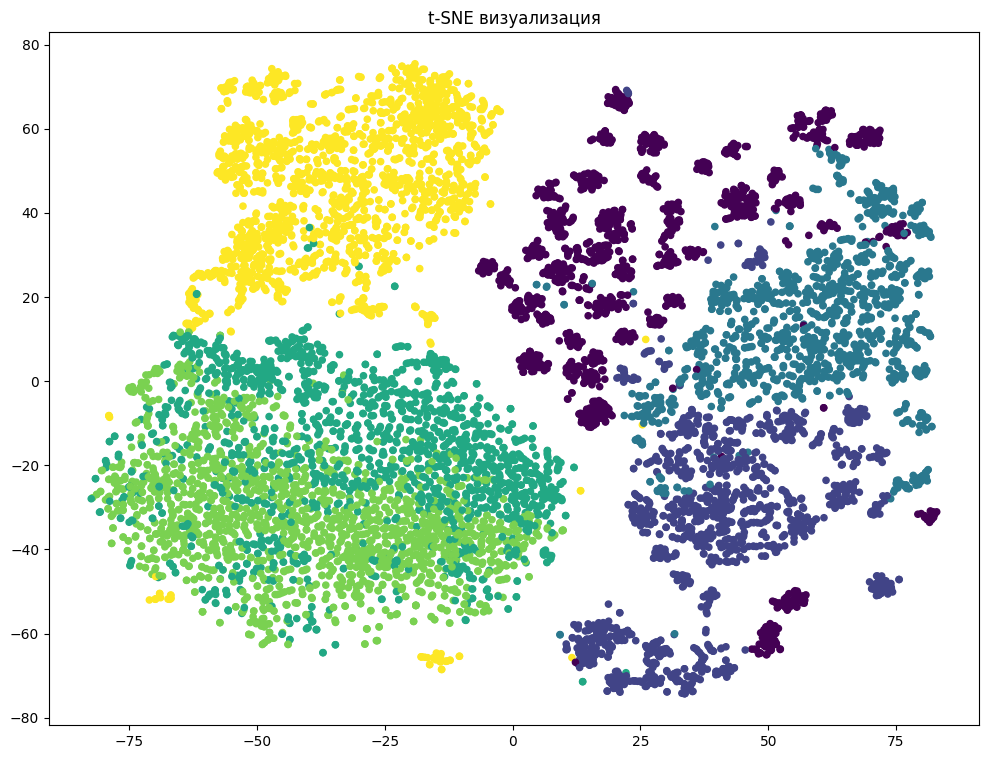

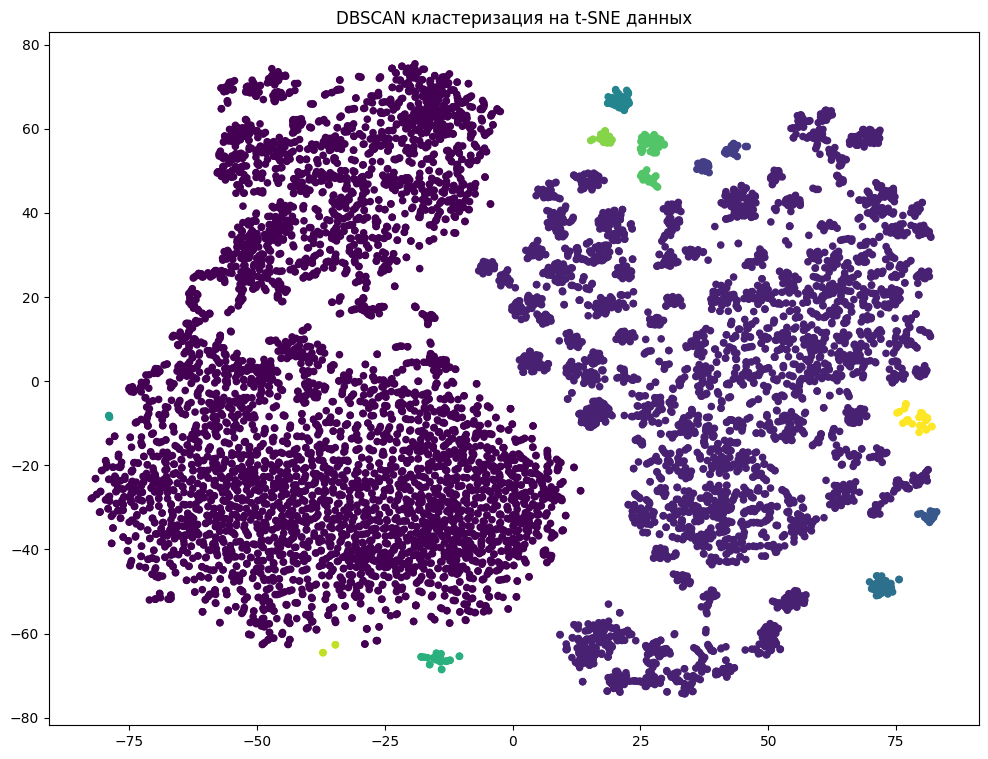

DBSCAN нашел 12 кластеров.


In [26]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
X_tsne = tsne.fit_transform(X_pca)

plt.figure(figsize=(12, 9))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=20, cmap='viridis')
plt.title('t-SNE визуализация')
plt.show()

dbscan = DBSCAN(eps=4.5, min_samples=4)
dbscan_labels = dbscan.fit_predict(X_tsne)

plt.figure(figsize=(12, 9))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, s=20, cmap='viridis')
plt.title('DBSCAN кластеризация на t-SNE данных')
plt.show()

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"DBSCAN нашел {n_clusters_dbscan} кластеров.")
